In [1]:
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import utils
import dataProcessing
from models.model import AttentionResNet
from models.refModel import RefConvNet

print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.1.0


In [2]:
seed = 1
tf.random.set_seed(seed)

In [3]:
# TODO: Uncomment this, only for debuging
# @tf.function
def trainStep(model, x, y, loss_op, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_op(y, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y, predictions)
    
# TODO: Uncomment this, only for debuging
# @tf.function
def testStep(model, x, y, loss_op, test_loss, test_accuracy):
    predictions = model(x)
    loss = loss_op(y, predictions)

    test_loss(loss)
    test_accuracy(y, predictions)

In [4]:
# x_train, y_train, x_test, y_test = utils.getCifar10Dataset()
x_train, y_train, x_test, y_test = utils.getMNISTDataset()

x_train = dataProcessing.normalize(x_train)
x_test = dataProcessing.normalize(x_test)
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

print('Data shape: {}'.format(x_test.shape[1:]))

Data shape: (28, 28, 1)


C:\Users\Jens\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


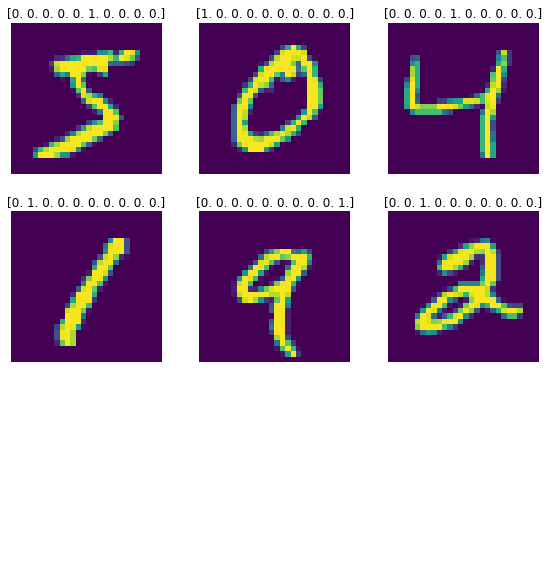

0

In [5]:
n_images_to_draw = 6
utils.drawImages(x_train[:n_images_to_draw], y_train[:n_images_to_draw])

In [6]:
def train(model, train_data, x_test, y_test, loss_op, optimization, epochs):
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
    test_loss = tf.keras.metrics.Mean(name='test_loss')
    test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

    n_batches = len(train_data)

    for epoch in range(epochs):
        n_batch = 0
        for x, y in train_data:
            n_batch+=1
            template = '[Batch {}/{}] Loss: {:.3f}, Accuracy: {:.2%}'
            print(template.format(n_batch, n_batches, train_loss.result(), train_accuracy.result()), end='\r')
            trainStep(model, x, y, loss_op, optimization, train_loss, train_accuracy)
            
            if n_batch >= n_batches:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break

        testStep(model, x_test, y_test, loss_op, test_loss, test_accuracy)

        template = '\n[Epoch {}/{}] Loss: {:.3f}, Accuracy: {:.2%}, Test Loss: {:.3f}, Test Accuracy: {:.2%}'
        print(template.format(epoch+1, epochs, train_loss.result(), train_accuracy.result(),
                test_loss.result(), test_accuracy.result()))

        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

    return model

In [21]:
data_shape = x_train.shape[1:]

learning_rate = 0.1
n_epochs = 5
n_batch_size = 128

loss_op = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(lr=learning_rate)

In [22]:
# First train a normal 2D conv network
model = keras.models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(data_shape[0], data_shape[1], data_shape[2])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [14]:
train(model, train_data, x_test, y_test, loss_op, optimizer, n_epochs)

NameError: name 'train_data' is not defined

In [23]:
# model.compile(optimizer=optimizer,
#               loss=loss_op,
#             #   loss='categorical_crossentropy',
#               metrics=['accuracy'])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=n_epochs, batch_size=n_batch_size, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 27s 444us/sample - loss: 0.2458 - accuracy: 0.9268 - val_loss: 0.0560 - val_accuracy: 0.9820
Epoch 2/5
60000/60000 [==============================] - 28s 462us/sample - loss: 0.0575 - accuracy: 0.9821 - val_loss: 0.0366 - val_accuracy: 0.9879
Epoch 3/5
60000/60000 [==============================] - 32s 531us/sample - loss: 0.0395 - accuracy: 0.9878 - val_loss: 0.0294 - val_accuracy: 0.9904
Epoch 4/5
60000/60000 [==============================] - 31s 510us/sample - loss: 0.0315 - accuracy: 0.9899 - val_loss: 0.0392 - val_accuracy: 0.9864
Epoch 5/5
20480/60000 [=========>....................] - ETA: 19s - loss: 0.0259 - accuracy: 0.9921